In [1]:
import sys
import argparse
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os
import time
import json
from keras import backend as K
K.set_learning_phase(1)
from keras.models import model_from_json
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.models import model_from_json
import types
from IPython.display import Image as PyImage
from IPython.core.display import HTML

Using TensorFlow backend.


In [2]:
target_size = (229, 229) 

In [3]:
def load_prediction_model(args):
    try:
        print (args.config_file[0]) 
        with open(args.config_file[0]) as json_file:
              model_json = json_file.read()
        model = model_from_json(model_json)
    except:
          print ("Please specify a model configuration file ...")
          sys.exit(1)
    try:
          model.load_weights(args.weights_file[0])
          print ("Loaded model weights from: " + str(args.weights_file[0]))
    except:
          print ("Error loading model weights ...")
          sys.exit(1)
    try:
        print (args.labels_file[0])
        with open(args.labels_file[0]) as json_file:
            labels = json.load(json_file)
        print ("Loaded labels from: " + str(args.labels_file[0]))
    except:
        print ("No labels loaded ...")
        sys.exit(1)
    #compile_model(model)
    return model, labels

In [4]:
args = types.SimpleNamespace()
args.config_file = ['/home/rahul/ICIAR/model_22.json']
args.weights_file = ['/home/rahul/ICIAR/trained_weights_22.model']
args.labels_file = ['/home/rahul/ICIAR/trained_labels.json']
args.output_dir = ['/home/rahul/']

In [5]:
model, labels = load_prediction_model(args)

/home/rahul/ICIAR/model_22.json
Loaded model weights from: /home/rahul/ICIAR/trained_weights_22.model
/home/rahul/ICIAR/trained_labels.json
Loaded labels from: /home/rahul/ICIAR/trained_labels.json


In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [7]:
layer_name = 'conv2d_76'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

In [8]:
layer_output.shape

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(192)])

In [9]:
args.image = ['/home/rahul/ICIAR/00.jpg']
img = Image.open(args.image[0])

In [10]:
def img_to_tensor(img, target_size):
  if img.size != target_size:
    img = img.resize(target_size)

  _x_ = image.img_to_array(img)
  _x_ = np.expand_dims(_x_, axis=0)
  _x_ = preprocess_input(_x_)
  return (_x_)

In [11]:
input_img = model.input

In [12]:
# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [13]:
input_img_data = img_to_tensor(img, target_size)

In [14]:
step = 1.
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [15]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 0, 2))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [16]:
img_proc = input_img_data[0]
img_proc = deprocess_image(img_proc)
imsave('%s_filter_%d.png' % (layer_name, filter_index), img_proc)
img_in = img.resize(target_size)
imsave('%s_%s.png' % ('input_img', layer_name),img_in)

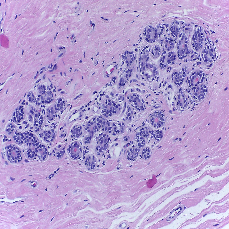

In [17]:
PyImage('%s_%s.png' % ('input_img', layer_name))

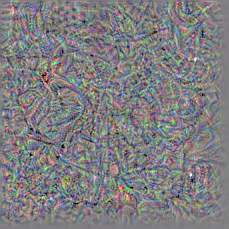

In [18]:
PyImage('%s_filter_%d.png' % (layer_name, filter_index))

In [19]:
layer_name = 'dense_3'
filter_index = 3  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, filter_index])

In [20]:
layer_output.shape

TensorShape([Dimension(None), Dimension(4)])

In [21]:
# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [22]:
step = 1.
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [23]:
img_proc = input_img_data[0]
img_proc = deprocess_image(img_proc)
imsave('%s_filter_%d.png' % (layer_name, filter_index), img_proc)
img_in = img.resize(target_size)
imsave('%s_%s.png' % ('input_img', layer_name),img_in)

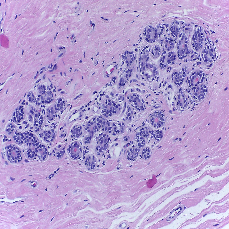

In [24]:
PyImage('%s_%s.png' % ('input_img', layer_name))

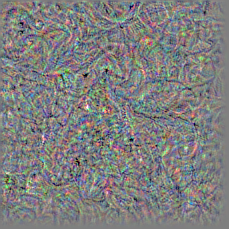

In [25]:
PyImage('%s_filter_%d.png' % (layer_name, filter_index))